In [34]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import dask.dataframe as dd
import dask.distributed
import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib.colors import SymLogNorm as symlog
from matplotlib import rcParams

import sklearn, sklearn.cluster
import matplotlib.pyplot as plt
import palettable

import seaborn as sns

pd.options.display.max_rows = 300
pd.options.display.max_columns = 100

In [2]:
client = dask.distributed.Client()

In [3]:
trips = dd.read_parquet('/data/all_trips.parquet', engine='fastparquet', index='trip_id',
                       columns=['pickup_datetime', 'dropoff_datetime', 
                                'pickup_taxizone_id', 'dropoff_taxizone_id',
                                'trip_distance', 'fare_amount', 'trip_type'
                               ])

/home/shekhar/anaconda3/lib/python3.5/site-packages/fastparquet/api.py:436: UserWarning: Regression warning: found category spec from fastparquet <= 0.0.6
  warnings.warn('Regression warning: found category spec from '


In [4]:
trips.head()

,pickup_datetime,dropoff_datetime,pickup_taxizone_id,dropoff_taxizone_id,trip_distance,fare_amount,trip_type
trip_id,,,,,,,
0,2009-01-01 00:00:00,2009-01-01 00:04:12,237.0,263.0,1.3,5.800000,yellow
1,2009-01-01 00:00:00,2009-01-01 00:05:03,114.0,249.0,0.9,5.400000,yellow
2,2009-01-01 00:00:02,2009-01-01 00:05:40,237.0,43.0,1.0,5.800000,yellow
3,2009-01-01 00:00:04,2009-01-01 00:03:08,261.0,261.0,0.8,4.600000,yellow
4,2009-01-01 00:00:07,2009-01-01 00:19:01,144.0,80.0,5.5,27.799999,yellow


In [7]:
trips.pickup_taxizone_id = trips.pickup_taxizone_id.fillna(266)
trips.dropoff_taxizone_id = trips.dropoff_taxizone_id.fillna(266)
trips = trips[trips.trip_type != 'uber']

In [8]:
mm = trips.groupby(['pickup_taxizone_id', 'dropoff_taxizone_id']).count().compute()

In [65]:
mm2 = mm.reset_index().sort_values('pickup_datetime', ascending=False)
# mm2 = mm2[mm2.pickup_datetime > 500]

In [66]:
mm2.pickup_taxizone_id = mm2.pickup_taxizone_id.astype(int)
mm2.dropoff_taxizone_id = mm2.dropoff_taxizone_id.astype(int)
mm2.head()

,pickup_taxizone_id,dropoff_taxizone_id,pickup_datetime,dropoff_datetime,trip_distance,fare_amount,trip_type
18445,266,266,25478914,25478914,25478914,25478914,25478914
16053,237,236,5694001,5694001,5694001,5694001,5694001
15857,236,237,5081429,5081429,5081429,5081429,5081429
16054,237,237,4815975,4815975,4815975,4815975,4815975
15856,236,236,4815481,4815481,4815481,4815481,4815481


In [67]:
k2 = np.zeros((268, 268))

In [69]:
for i, j, N in zip(mm2.pickup_taxizone_id.astype(int), mm2.dropoff_taxizone_id.astype(int), mm2.pickup_datetime):
    k2[i, j] = N

In [70]:
k2 += 1.
k2 = np.log10(k2)

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


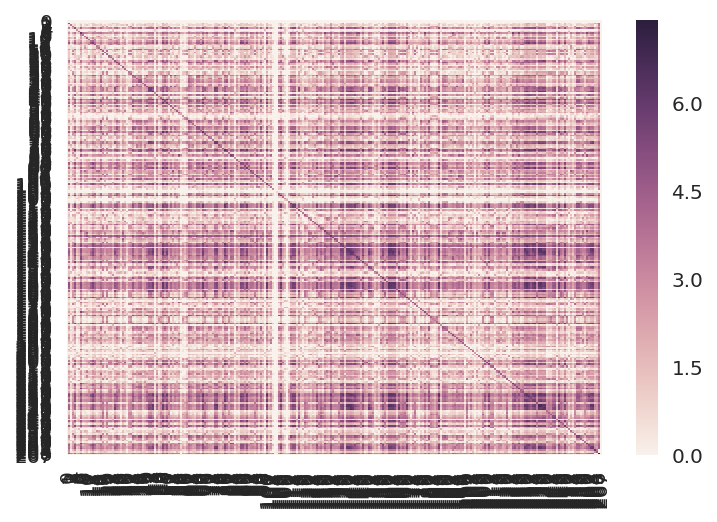

In [71]:
sns.heatmap(k2)

In [125]:
k2.nbytes

574592

In [72]:
gdf = gpd.read_file('../shapefiles/taxi_zones.shp')

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


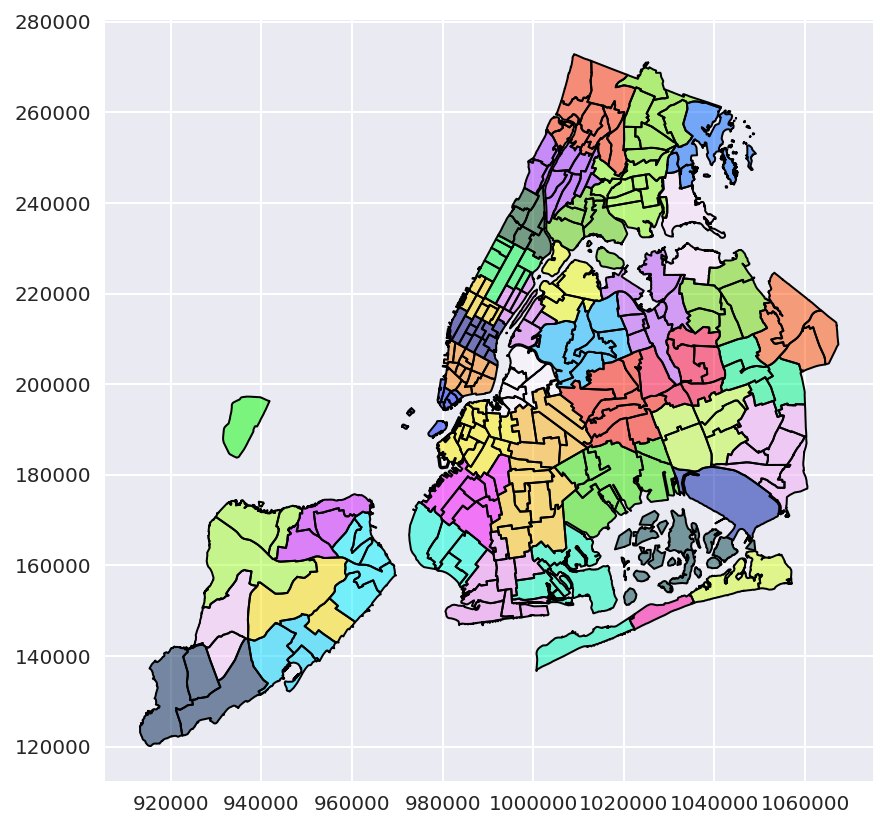

In [127]:
X1 = np.array([(p.x, p.y) for p in gdf.geometry.centroid.values])
km = sklearn.cluster.KMeans(45, random_state=43)
km.fit(X1)
gdf['labels'] = km.labels_
gdf.plot(column='labels', cmap=plt.cm.gist_ncar_r)
plt.gcf().set_size_inches(7, 7)

In [74]:
gdf.head()

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,geometry,zone,labels
0,1,1,0.000782,0.116357,EWR,"POLYGON ((933100.9183527103 192536.0856972019,...",Newark Airport,30
1,2,2,0.004866,0.433470,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1...",Jamaica Bay,41
2,3,3,0.000314,0.084341,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,...",Allerton/Pelham Gardens,26
3,4,4,0.000112,0.043567,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",Alphabet City,15
4,5,5,0.000498,0.092146,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ...",Arden Heights,2


In [75]:
gdf2 = gdf[['LocationID', 'labels']]

In [76]:
mm3 = mm2.merge(gdf2, left_on='pickup_taxizone_id', right_on='LocationID', how='left').drop('LocationID', axis=1)

In [77]:
mm3 = mm3.rename(columns={'labels': 'pickup_cluster_id'})

In [78]:
mm3

,pickup_taxizone_id,dropoff_taxizone_id,pickup_datetime,dropoff_datetime,trip_distance,fare_amount,trip_type,pickup_cluster_id
0,266,266,25478914,25478914,25478914,25478914,25478914,NaN
1,237,236,5694001,5694001,5694001,5694001,5694001,5.0
2,236,237,5081429,5081429,5081429,5081429,5081429,31.0
3,237,237,4815975,4815975,4815975,4815975,4815975,5.0
4,236,236,4815481,4815481,4815481,4815481,4815481,31.0
5,237,161,3059531,3059531,3059531,3059531,3059531,5.0
6,237,162,2924670,2924670,2924670,2924670,2924670,5.0
7,239,142,2873235,2873235,2873235,2873235,2873235,31.0
8,79,79,2816956,2816956,2816956,2816956,2816956,15.0
9,239,238,2718197,2718197,2718197,2718197,2718197,31.0


In [79]:
mm3 = mm3.merge(gdf2, left_on='dropoff_taxizone_id', right_on='LocationID', how='left').drop('LocationID', axis=1)
mm3 = mm3.rename(columns={'labels': 'dropoff_cluster_id'})

In [81]:
mm4 = mm3.fillna(45.)

In [93]:
mm5 = (mm4['pickup_cluster_id dropoff_cluster_id pickup_datetime'.split()] 
    .groupby(['pickup_cluster_id', 'dropoff_cluster_id']).sum().reset_index())

In [94]:
mm5.pickup_cluster_id = mm5.pickup_cluster_id.astype(int)
mm5.dropoff_cluster_id = mm5.dropoff_cluster_id.astype(int)

In [96]:
mm5.head()

,pickup_cluster_id,dropoff_cluster_id,pickup_datetime
0,0,0,4851108
1,0,1,1886
2,0,2,77
3,0,3,1882
4,0,4,16032


In [95]:
k3 = np.zeros((46, 46))

In [98]:
for i, j, N in zip(mm5.pickup_cluster_id.astype(int), mm5.dropoff_cluster_id.astype(int), mm5.pickup_datetime):
    k3[i, j] = N

In [99]:
k3 += 1.
k3 = np.log10(k3)

/home/shekhar/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


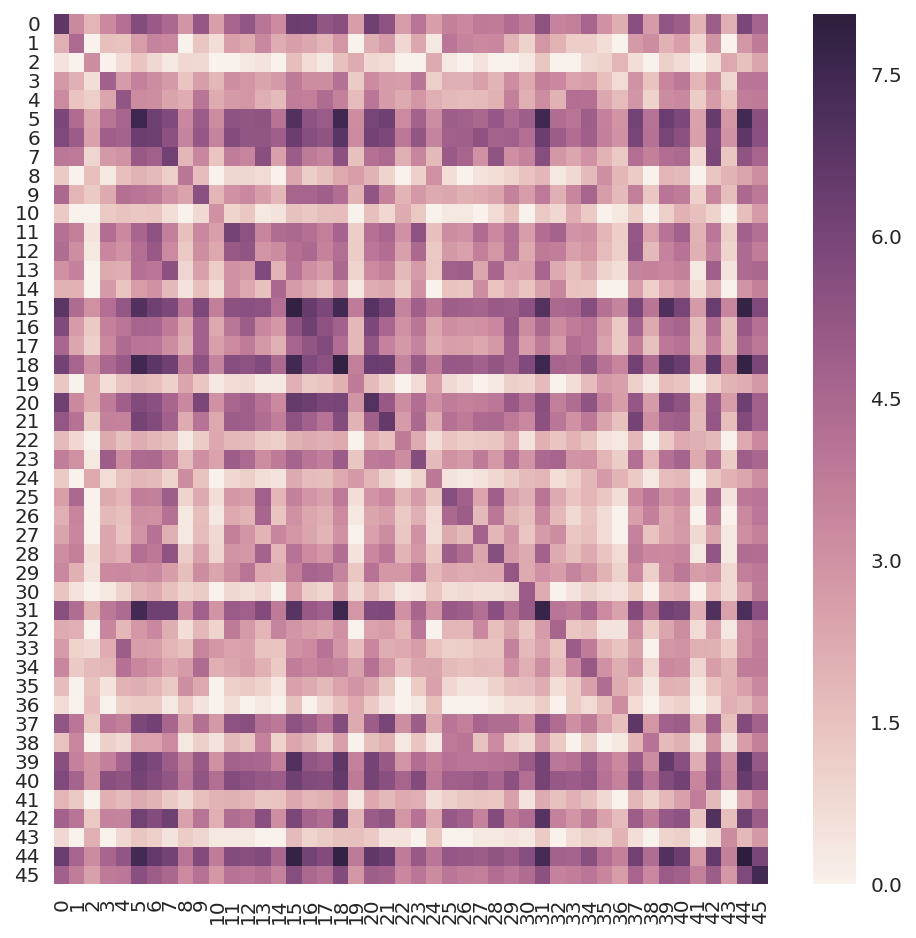

In [126]:
sns.heatmap(k3)
plt.gcf().set_size_inches(8, 8)

In [110]:
gdf['l'] = gdf['labels']

In [123]:
gdf[gdf.l == 18]

,LocationID,OBJECTID,Shape_Area,Shape_Leng,borough,geometry,zone,labels,l
47,48,48,0.000094,0.043747,Manhattan,"POLYGON ((986694.3125067502 214463.8461607993,...",Clinton East,18,18
49,50,50,0.000173,0.055748,Manhattan,"POLYGON ((985170.3721923977 221087.3887939602,...",Clinton West,18,18
141,142,142,0.000076,0.038176,Manhattan,"POLYGON ((989380.3045081049 218980.2473062277,...",Lincoln Square East,18,18
142,143,143,0.000151,0.054180,Manhattan,"POLYGON ((989338.1001118571 223572.2528185844,...",Lincoln Square West,18,18
160,161,161,0.000072,0.035804,Manhattan,"POLYGON ((991081.0260630846 214453.6983589679,...",Midtown Center,18,18
161,162,162,0.000048,0.035270,Manhattan,"POLYGON ((992224.354090333 214415.2926926613, ...",Midtown East,18,18
162,163,163,0.000041,0.034177,Manhattan,"POLYGON ((989412.6634775698 219020.9428979903,...",Midtown North,18,18
229,230,230,0.000056,0.031028,Manhattan,"POLYGON ((988786.8773103654 214532.0940539986,...",Times Sq/Theatre District,18,18
